In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Load the NetCDF file
# Replace 'your_file.nc' with the path to your NetCDF file
data = xr.open_dataset('eobs_0.25_2006_20.nc')

In [3]:
# Print the dataset to understand its structure and variables
print(data)

<xarray.Dataset>
Dimensions:    (time: 5479, longitude: 464, latitude: 201)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2020-12-31
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
Data variables:
    rr         (time, latitude, longitude) float32 ...
Attributes:
    CDI:            Climate Data Interface version 2.4.1 (https://mpimet.mpg....
    Conventions:    CF-1.4
    E-OBS_version:  29.0e
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Jul 26 13:26:01 2024: cdo selyear,2006/2020 rr_ens_me...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....
    CDO:            Climate Data Operators version 2.4.1 (https://mpimet.mpg....


In [4]:
precipitation = data['rr']

In [5]:
# Calculate the mean precipitation over time
mean_precipitation = precipitation.mean(dim='time')

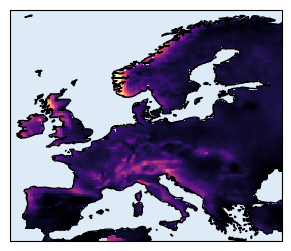

In [7]:
# Define a function to plot the data
def plot_precipitation(mean_precip, extent,vmin,vmax,label, cmap_color='viridis'):
    fig = plt.figure(figsize=(4.5, 3))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add features for better visualization
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='#deebf7')
    ax.add_feature(cfeature.COASTLINE)

    # Plot the mean precipitation
    img = ax.pcolormesh(mean_precip['longitude'], mean_precip['latitude'], mean_precip, cmap=cmap_color, transform=ccrs.PlateCarree(),vmin=vmin, vmax=vmax)

    # Add a colorbar
    #cbar = plt.colorbar(img, ax=ax, orientation='vertical',  shrink=0.6, extend='both')
    #cbar.set_label(label)


    plt.show()

# Define the extent of the map [lon_min, lon_max, lat_min, lat_max]
europe_extent = [-11.5, 32, 35, 72] 

# Plot the mean precipitation
plot_precipitation(mean_precipitation, europe_extent,vmin=1, vmax=8, cmap_color='magma',label='Mean wet day Precip E-OBS')

In [8]:
# Filter for wet days (days with precipitation > 1 mm)
wet_days = precipitation.where(precipitation > 1.0)

# Calculate the mean precipitation over wet days
mean_wet_precipitation = wet_days.mean(dim='time')

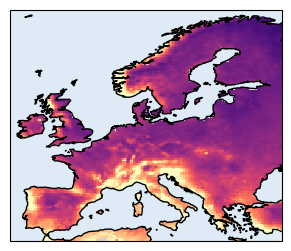

In [9]:
plot_precipitation(mean_wet_precipitation, europe_extent,cmap_color='magma',vmin =2,vmax=10, label='wet_day_mean EOBS')

In [10]:
# Calculate the 95th percentile of precipitation over wet days
percentile_95_wet_days = wet_days.quantile(0.95, dim='time', skipna=True)

c:\Users\as2023\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


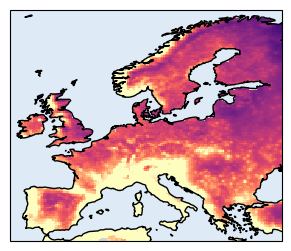

In [11]:
plot_precipitation(percentile_95_wet_days, europe_extent,cmap_color='magma',vmin =4,vmax=22, label='wet_day_95th EOBS')

In [12]:
# Function to calculate lag-1 Spearman autocorrelation for a time series
from scipy.stats import spearmanr
# Function to calculate lag-1 Spearman autocorrelation for a time series
def lag_1_spearman_autocorrelation(time_series):
    # Ensure the series has at least two values to compute correlation
    if len(time_series) < 2:
        return np.nan
    # Remove NaN values by using boolean indexing
    valid_values = ~np.isnan(time_series)
    valid_series = time_series[valid_values]
    if len(valid_series) < 2:
        return np.nan
    # Calculate Spearman correlation between series and its lagged version
    return spearmanr(valid_series[:-1], valid_series[1:]).correlation

# Calculate lag-1 Spearman autocorrelation for each grid cell
lag_1_spearman = xr.apply_ufunc(
    lag_1_spearman_autocorrelation,
    precipitation,
    input_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',  # Use parallelization for large datasets
    output_dtypes=[float]
)

c:\Users\as2023\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


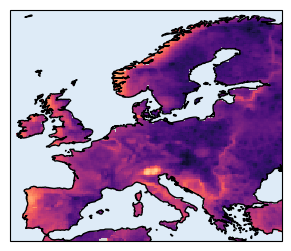

In [13]:
plot_precipitation(lag_1_spearman, europe_extent,cmap_color='magma',vmin =0.2,vmax=0.7, label='spearman EOBS')

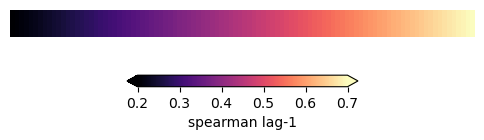

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot only the colorbar
def plot_colorbar(vmin, vmax, cmap_color='coolwarm', label='Spearman Lag-1 Autocorrelation'):
    # Create a dummy image
    dummy_data = np.linspace(vmin, vmax, 100).reshape(1, 100)

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(6, 1))
    
    # Remove axes
    ax.set_axis_off()
    
    # Add colorbar 
    cax = ax.imshow(dummy_data, aspect='auto', cmap=cmap_color)
    
    # Create colorbar
    cbar = fig.colorbar(cax, orientation='horizontal', pad=0.5, extend = 'both')
    cbar.set_label(label)
    
    plt.show()

# Define vmin and vmax for the colorbar
vmin = .2  # Minimum value for the colorbar
vmax = .7   # Maximum value for the colorbar

# Plot only the colorbar
plot_colorbar(vmin, vmax, cmap_color='magma', label='spearman lag-1')
